In [62]:
# -*- coding: utf-8 -*-
##Python matplotlib
##Make whisker plots of ToE hist+RCP85 vs. histNat (or Picontrol) in all 5 domains, with x axis being the tas anomaly
##>1std and >2std

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset as open_ncfile
from maps_matplot_lib import defVarmme
from modelsDef import defModels
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import glob
import os
import datetime
from scipy.interpolate import griddata

In [3]:
# ----- Work -----

# Directory
indir_rcphn = '/home/ysilvy/Density_bining/Yona_analysis/data/toe_rcp85_histNat_average_signal/'
indir_rcppiC = '/home/ysilvy/Density_bining/Yona_analysis/data/toe_rcp85_PiControl_average_signal/'
indir_tas = '/home/ysilvy/Density_bining/Yona_analysis/data/tas/'

models = defModels()

domains = ['Southern ST', 'SO', 'Northern ST', 'North Atlantic', 'North Pacific']

varname = defVarmme('salinity'); v = 'S'

method = 'average_signal' # Average signal and noise in the box, then compute ToE
method_noise_rcp = 'average_histNat' # Average histNat in the specified domains then determine the std of this averaged value

In [4]:
# === INPUTS ===

use_piC = False # signal = hist+RCP - histNat, noise = std(histNat)
# use_piC = True # signal = hist+RCP - PiControl, noise = std(PiControl)

if use_piC == True and method_noise_rcp == 'average_histNat':
    method_noise_rcp = 'average_piC' # Just change the notation for coherence and for data path
else:
    # runs_rcp = 'same' # Same runs (30 runs) for hist+RCP8.5 vs. histNat as for hist+RCP8.5 vs. PiControl
    runs_rcp = 'all' # All runs (35)

# output format
outfmt = 'view'
# outfmt = 'save'

# ===========

In [5]:
# ----- Variables ------
var = varname['var_zonal_w/bowl']
legVar = varname['legVar']
unit = varname['unit']

timN = 240

In [19]:
# ----- Read ToE and tas for each model ------

# == Historical + RCP8.5 vs. historicalNat or vs. PiControl ==

nruns = 0 # Initialize total number of runs
nrunmax = 100
nMembers = np.ma.empty(len(models)) # Initialize array for keeping number of members per model

# -- Initialize varToE 1 and 2 containing ToE of all runs
varToEA_1 = np.ma.masked_all((nrunmax, len(domains)))
varToEP_1 = np.ma.masked_all((nrunmax, len(domains)))
varToEI_1 = np.ma.masked_all((nrunmax, len(domains)))
varToEA_2 = np.ma.masked_all((nrunmax, len(domains)))
varToEP_2 = np.ma.masked_all((nrunmax, len(domains)))
varToEI_2 = np.ma.masked_all((nrunmax, len(domains)))

# -- Initialize tas
tas = np.ma.masked_all((timN,nrunmax))

# -- Loop over models
if use_piC == True:
    indir = indir_rcppiC
else:
    indir = indir_rcphn
listfiles = glob.glob(indir + method_noise_rcp + '/*.nc')
nmodels = len(listfiles)

for i in range(nmodels):

    file_toe = listfiles[i]
    ftoe = open_ncfile(file_toe, 'r')
    name = os.path.basename(file_toe).split('.')[1]

    # Ignore FGOALS-g2: no tas
    if name != 'FGOALS-g2':

        # If use same runs in vs. histNat as in vs. PiControl, take out deficient models
        if (runs_rcp == 'all') or (runs_rcp =='same' and name != 'GISS-E2-R' and name != 'FGOALS-g2' and name != 'MIROC-ESM'):

            # Read ToE (members, basin, domain)
            toe1read = ftoe.variables[var + 'ToE1'][:]
            toe2read = ftoe.variables[var + 'ToE2'][:]
            nMembers[i] = int(toe2read.shape[0])
            print('- Reading ToE of %s with %d members'%(name,nMembers[i]))
            nruns1 = int(nruns + nMembers[i])

            # Save ToE
            varToEA_1[nruns:nruns1,:] = toe1read[:,1,:]
            varToEP_1[nruns:nruns1,:] = toe1read[:,2,:]
            varToEI_1[nruns:nruns1,:] = toe1read[:,3,:]
            varToEA_2[nruns:nruns1,:] = toe2read[:,1,:]
            varToEP_2[nruns:nruns1,:] = toe2read[:,2,:]
            varToEI_2[nruns:nruns1,:] = toe2read[:,3,:]

            # Read tas
            file_tas = glob.glob(indir_tas + '*'+name+'*.nc')[0] # File
            ftas = open_ncfile(file_tas, 'r')
            tasread = ftas.variables['tas'][:]
            # Save tas
            tas[:,nruns:nruns1] = tasread

            nruns = nruns1


print('Total number of runs:', nruns)
varToEA_1 = varToEA_1[0:nruns,:]
varToEP_1 = varToEP_1[0:nruns,:]
varToEI_1 = varToEI_1[0:nruns,:]
varToEA_2 = varToEA_2[0:nruns,:]
varToEP_2 = varToEP_2[0:nruns,:]
varToEI_2 = varToEI_2[0:nruns,:]

tas = tas[:,0:nruns]

nruns = int(nruns)

if use_piC == False and runs_rcp == 'same':
        nmodels=nmodels-3

- Reading ToE of GISS-E2-R with 3 members
- Reading ToE of CCSM4 with 6 members
- Reading ToE of CESM1-CAM5 with 3 members
- Reading ToE of MIROC-ESM with 1 members
- Reading ToE of MIROC-ESM-CHEM with 1 members
- Reading ToE of HadGEM2-ES with 2 members
- Reading ToE of CSIRO-Mk3-6-0 with 9 members
- Reading ToE of IPSL-CM5A-MR with 1 members
- Reading ToE of CanESM2 with 5 members
- Reading ToE of IPSL-CM5A-LR with 3 members
('Total number of runs:', 34)


In [38]:
# ---- Associate ToE to tas anomaly ----

# -- Compute tas anomaly
y1=1880
y2=1919
tas_anom = tas - np.ma.average(tas[y1-1860:y2-1860+1,:],axis=0) 

maskdata  = np.nan
time = np.arange(1861,2101)

# Make new data associating each ToE to its corresponding temperature anomaly
def associate_tas_ToE(varToE,time,tas_anom):
    """ Make new data array associating each ToE to its corresponding temperature anomaly """
    ndomains = varToE.shape[1]
    nruns = varToE.shape[0]
    varToE_tas = np.ma.empty((nruns,ndomains))
    
    for idomain in range(ndomains): # Loop on regions
        for irun in range(nruns): # Loop on all realizations
            toe = varToE[irun,idomain] # Read ToE 
            if not np.ma.is_masked(toe):
                iyear = np.argwhere(time==toe)[0][0] # Read index of said ToE in time vector
                varToE_tas[irun,idomain] = tas_anom[iyear,irun] # Fill new data array with tas anomaly
            else:
                varToE_tas[irun,idomain] = np.ma.masked
    
    return varToE_tas

varToEA_1_tas = associate_tas_ToE(varToEA_1,time,tas_anom)
varToEP_1_tas = associate_tas_ToE(varToEP_1,time,tas_anom)
varToEI_1_tas = associate_tas_ToE(varToEI_1,time,tas_anom)
varToEA_2_tas = associate_tas_ToE(varToEA_2,time,tas_anom)
varToEP_2_tas = associate_tas_ToE(varToEP_2,time,tas_anom)
varToEI_2_tas = associate_tas_ToE(varToEI_2,time,tas_anom)

In [47]:
# -- Turn masked data into nans

varToEA_1_tas[np.ma.getmask(varToEA_1_tas)] = np.nan
varToEP_1_tas[np.ma.getmask(varToEP_1_tas)] = np.nan
varToEI_1_tas[np.ma.getmask(varToEI_1_tas)] = np.nan
varToEA_2_tas[np.ma.getmask(varToEA_2_tas)] = np.nan
varToEP_2_tas[np.ma.getmask(varToEP_2_tas)] = np.nan
varToEI_2_tas[np.ma.getmask(varToEI_2_tas)] = np.nan

In [48]:
# -- Organize data

# tas ToE 1 [>1std] hist+rcp8.5 vs. histNat (or vs. PiControl)
data1 = [varToEA_1_tas[:,0], varToEP_1_tas[:,0], varToEI_1_tas[:,0], maskdata, varToEP_1_tas[:,2], varToEI_1_tas[:,2], 
         maskdata, varToEA_1_tas[:,1], varToEP_1_tas[:,1], varToEI_1_tas[:,1], maskdata, varToEA_1_tas[:,3], maskdata, 
         varToEP_1_tas[:,4]]
data1 = data1[::-1]

# tas ToE 2 [>2std]
data2 = [varToEA_2_tas[:,0], varToEP_2_tas[:,0], varToEI_2_tas[:,0], maskdata, varToEP_2_tas[:,2], varToEI_2_tas[:,2], 
         maskdata, varToEA_2_tas[:,1], varToEP_2_tas[:,1], varToEI_2_tas[:,1], maskdata, varToEA_2_tas[:,3], maskdata, 
         varToEP_2_tas[:,4]]
data2 = data2[::-1]

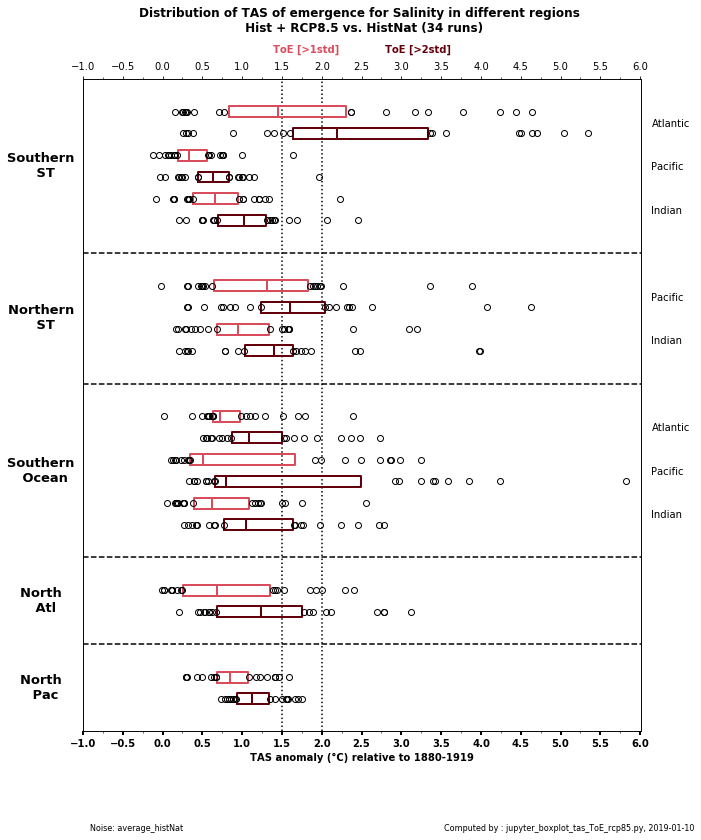

In [71]:
# ----- Plot ------

labels = ['','','','','Indian','Pacific','Atlantic','','Indian','Pacific','','Indian','Pacific','Atlantic']
N = 15
ind = np.arange(1,N)
width = 0.25

fig, ax = plt.subplots(figsize=(10,12))

ax.axvline(x=1.5, color='black', ls=':')
ax.axvline(x=2, color='black', ls=':')
ax.axvline(x=0, color='black', ls=':')

# ToE 2 Hist+rcp8.5 vs. HistNat (or vs. PiControl) boxes
boxes1 = ax.boxplot(data2, vert=0, positions=ind-width, widths=width, whis=0)
for box in boxes1['boxes']:
    box.set(color='#64000b', linewidth=2) #c90016
for whisker in boxes1['whiskers']:
    whisker.set(color='#64000b', linestyle='-', linewidth=1)
for cap in boxes1['caps']:
    cap.set(color='#64000b', linewidth=1)
for flier in boxes1['fliers']:
    flier.set(color='#64000b')
for median in boxes1['medians']:
    median.set(color='#64000b', linewidth=2)


ax.set_xlim([-1,6.01])
ax.set_xlabel('TAS anomaly ('+degree_sign+'C) relative to '+str(y1)+'-'+str(y2), fontweight='bold')
ax.yaxis.set_tick_params(left='off', right='off', labelright='on', labelleft='off', pad=7)
xmajorLocator = MultipleLocator(0.5)
xminorLocator = AutoMinorLocator(2)
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.xaxis.set_tick_params(which='major',width=2)

ax2 = ax.twiny()
# ToE 1 Hist+rcp8.5 vs. HistNat (or vs. PiControl) boxes
boxes2 = ax2.boxplot(data1, vert=0, positions=ind+width, widths=width, whis=0)
for box in boxes2['boxes']:
    box.set(color='#d94c5b', linewidth=2)
for whisker in boxes2['whiskers']:
    whisker.set(color='#d94c5b', linestyle='-', linewidth=1)
for cap in boxes2['caps']:
    cap.set(color='#d94c5b', linewidth=1)
for flier in boxes2['fliers']:
    flier.set(color='#d94c5b')
for median in boxes2['medians']:
    median.set(color='#d94c5b', linewidth=2)


ax2.set_xlim([-1,6.01])
ax2.set_yticks(ind)
ax2.set_yticklabels(labels, fontweight='bold')
ax2.yaxis.set_tick_params(left='off', right='off')
ax2.set_ylim([0,15])
xmajorLocator2 = MultipleLocator(0.5)
xminorLocator2 = AutoMinorLocator(2)
ax2.xaxis.set_major_locator(xmajorLocator2)
ax2.xaxis.set_minor_locator(xminorLocator2)

plt.setp(ax.get_yticklabels(), visible=True)
plt.setp(ax.get_xticklabels(), fontweight='bold')

ax2.axhline(y=ind[1], color='black', ls='--')
ax2.axhline(y=ind[3], color='black', ls='--')
ax2.axhline(y=ind[7], color='black', ls='--')
ax2.axhline(y=ind[10], color='black', ls='--')

# Domain labels
ax2.text(-1-0.5,ind[0], 'North \n Pac', ha='center', va='center', fontweight='bold', fontsize=13)
ax2.text(-1-0.5,ind[2], 'North \n Atl', ha='center', va='center', fontweight='bold', fontsize=13)
ax2.text(-1-0.5,ind[5], 'Southern \n Ocean', ha='center', va='center', fontweight='bold', fontsize=13)
ax2.text(-1-0.5,ind[8]+width, 'Northern \n ST', ha='center', fontweight='bold', fontsize=13)
ax2.text(-1-0.5,ind[12], 'Southern \n ST', ha='center', va='center', fontweight='bold', fontsize=13)

if use_piC == True:
    title = 'Hist + RCP8.5 vs. PiControl'
    end_name = 'use_piC'
    end_noise = 'RCP8.5 vs. PiControl'
else:
    title = 'Hist + RCP8.5 vs. HistNat'
    end_name = 'use_histNat'
    end_noise = 'RCP8.5 vs. HistNat'
plotTitle = 'Distribution of TAS of emergence for '+legVar+ ' in different regions \n '+title+ ' ('+str(nruns)+' runs)'
ax.set_title(plotTitle, y=1.08, fontweight='bold', va='center')
ax2.text(0.4,1.045, 'ToE [>1std]', color='#d94c5b',
         va='center', ha='center',transform=ax2.transAxes, fontweight='bold')
ax2.text(0.6,1.045, 'ToE [>2std]', color='#64000b',
         va='center', ha='center',transform=ax2.transAxes, fontweight='bold')

# Date
now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d")

# Text at the bottom of the figure
plt.figtext(.8,.01,'Computed by : jupyter_boxplot_tas_ToE_rcp85.py, '+date, fontsize=8, ha='center')
plt.figtext(.2,.01,'Noise: %s' %(method_noise_rcp), fontsize=8, ha='center')
if use_piC :
    plt.figtext(.5,.01,'PiControl : mean(last_240_years)',fontsize=9,ha='center')

if (use_piC==False and runs_rcp == 'all') or use_piC==True:
    plotName = 'TASoE_boxplot_RCP85_' + method_noise_rcp + '_' + end_name
else:
    plotName = 'TASoE_boxplot_RCP85_' + method_noise_rcp + '_' + end_name + '_samerunsvsPiC'

In [54]:
if outfmt == 'view':
    plt.show()
else:
    plt.savefig('/home/ysilvy/Density_bining/Yona_analysis/figures/models/ToE/boxplots/'+plotName+'.png')

In [69]:
'TAS anomaly ('+degree_sign+'C) relative to '+str(y1)+'-'+str(y2)

u'TAS anomaly (\xb0C) relative to 1880-1919'

In [64]:
degree_sign= u'\N{DEGREE SIGN}'

In [68]:
print(degree_sign)

°


�


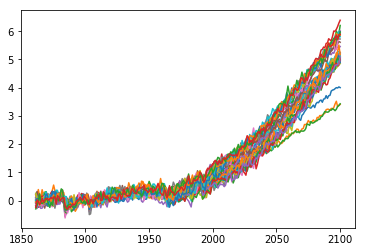

In [72]:
plt.plot(time,tas_anom)